<a href="https://colab.research.google.com/github/Many98/01NAEX/blob/main/Protokol_EF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01NAEX - Protocol: XGBoost Hyperparameter search




In [ ]:
cat(system('sudo apt-get install -y gmp', intern=TRUE), sep = "\n")
cat(system('sudo apt-get install -y partitions', intern=TRUE), sep = "\n")
cat(system('sudo apt-get install -y DoE.base', intern=TRUE), sep = "\n")

list_of_packages <- c("tidyverse", "car","nortest","lattice","pwr","MASS",
                      "agricolae", "FrF2")
missing_packages <- list_of_packages[!(list_of_packages %in% installed.packages()[,"Package"])]

if(length(missing_packages)) install.packages(missing_packages)
lapply(list_of_packages, library, character.only = TRUE)

# Zadanie

# TODO
- xgboost model bol trénovaný na predikciu ceny bytov v (CZK) na základe tabulárnych dát. Pripravený dataset obsahoval celkovo 8191 vzoriek pričom 85% (6962) dát bolo použitých na tréning
a zvyšných 15% (1229) na test predikčných vlastností modelu. Hodnotenou metrikou je MAE (v CZK). 

- Cieľom je teda optimalizácia MAE vzhľadom k sledovaným hyperparametrom



- dodatocne parametre
- L2 norma ako stratova fce
- tree_method bola nastavená na hist
- booster 'gbtree
- random_state=42

### Uvažované úrovne hyperparametrov

(Úrovne tiež definujú horné a spodné hranice pre randomizovaný hyperparameter search)

315K/25K

|       |              **factor** |   **-1** |   **1** | **0 (centerpoint)**   |
|-------|------------------------:|--------:|--------:|-----------------:|
| **A** |           *colsample_bytree* |     0.5 |     1.0 |              0.75 |
| **B** |              *colsample_bynode* |     0.5 |     1.0 |              0.75 |
| **C** |                 *max_depth* |     3 |     15  |             9     |
| **D** |               *learning_rate* | 0.08999 | 0.15 |              0.119995    |
| **E** |*n_estimators* |     100 |     700 |              400 |
| **F** |            *subsample* |     0.5 |      1.0 |          0.75        |
| **G** |            *gamma* |     0.0 |      1.0 |         0.5         |
| **H** |            *max_leaves* |     0 |      100 |              50    |




* max_leaves: 0 or 100
* max_depth: 3 or 15
* learning_rate: 0.08999 or 0.15
* n_estimators: 100 or 700
* gamma: 0 or 1
* subsample: 0.5 or 1
* colsample_bytree: 0.5 or 1
* colsample_bynode: 0.5 or 1	

Na návrh experimentu používame 2^(8-2) dizajn.

Ak označíme faktory naslednovne pričom predpokladáme, že posledné dva nebudú mať významný vplyv na výslednú hodnotu MAE metriky:

*   colsample_bytree - A
*   colsample_bynode - B
*   max_depth	- C
*   learning_rate	- D
*   n_estimators - E	
*   subsample - F	
*   gamma	- G
*   max_leaves - H 

Tak získame takúto štruktúru generátorov: 
 - G = ABCD, H = ABEF

a definujúce vzťahy sú:

 - I = ABCDG = ABEFH = CDEFGH.


A(ABCD) = BCD = BEG = ACDEG
B(ABCD) = ACD = AEG = BCDEG
C(ABCD) = 
  
Rozlišenie modelu (resolution) je teda typu V.

Dodatočne bolo vykonaných 5 replikovaných meraní v centrálnych bodoch.

# TODO

Alternative generators are G = -ABCD, H = -ABEF.

# Použitý dizajn

Bohužial som pozabudol nastaviť konkrétny seed
a preto musíme merania následne preusporiadať

In [2]:
design =FrF2(2^(8-2), 8, replications = 1, randomize = TRUE, seed=42,
generators=c("ABCD","ABEF"), 
factor.names = c("colsample_bytree", "colsample_bynode",
                 "max_depth", "learning_rate", "n_estimators", "subsample",
                 "gamma", "max_leaves")
                 )

# export for later measurement in python
# write.csv(design, "design.csv", row.names=FALSE)
    
head(design)   

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,-1,-1,-1,-1,1,1,1,1
2,-1,-1,1,-1,-1,1,-1,-1
3,-1,-1,-1,-1,-1,-1,1,1
4,-1,-1,-1,1,1,-1,-1,-1
5,1,-1,-1,1,-1,-1,1,-1
6,1,1,-1,-1,-1,1,1,-1


# Namerané dáta podľa (permutácie) vyššie uvedeného dizajnu

In [3]:
measured_design <- read.table("https://raw.githubusercontent.com/Many98/01NAEX/main/naex_design_measure.csv",header=TRUE,sep=",")

head(measured_design, 10)

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,-1,-1,1,-1,-1,1,-1,-1,164889.9,8864.859
2,1,-1,1,1,1,-1,-1,1,110614.2,2947.114
3,1,-1,-1,1,-1,-1,1,-1,225543.5,156722.187
4,-1,1,1,1,1,-1,-1,1,181386.2,5386.096
5,-1,-1,-1,-1,-1,-1,1,1,366604.9,322576.647
6,-1,1,-1,-1,1,1,-1,-1,121446.5,54506.775
7,-1,-1,1,-1,1,1,-1,1,165075.3,9484.155
8,-1,-1,-1,1,-1,1,-1,-1,283431.2,218493.501
9,-1,1,1,1,-1,1,-1,1,137987.5,35350.215


# Skutočné hodnoty sledovaných hyperparametrov

In [4]:
data <- read.table("https://raw.githubusercontent.com/Many98/01NAEX/main/naex_design_measure_values.csv",header=TRUE,sep=",")
head(data)


,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,0.5,0.5,15,0.08999,100,1.0,0,0,164889.9,8864.859
2,1.0,0.5,15,0.15000,700,0.5,0,100,110614.2,2947.114
3,1.0,0.5,3,0.15000,100,0.5,1,0,225543.5,156722.187
4,0.5,1.0,15,0.15000,700,0.5,0,100,181386.2,5386.096
5,0.5,0.5,3,0.08999,100,0.5,1,100,366604.9,322576.647
6,0.5,1.0,3,0.08999,700,1.0,0,0,121446.5,54506.775


# Korekcia FrF dizajn objektu aby sedel na naše meranie

In [5]:
design$colsample_bytree = measured_design[1:64, 'colsample_bytree']
design$colsample_bynode= measured_design[1:64, 'colsample_bynode']
design$max_depth = measured_design[1:64, 'max_depth']
design$learning_rate = measured_design[1:64, 'learning_rate']
design$n_estimators = measured_design[1:64, 'n_estimators']
design$subsample = measured_design[1:64, 'subsample']
design$gamma = measured_design[1:64, 'gamma']
design$max_leaves = measured_design[1:64, 'max_leaves']


# Adding response (testing mean absolute error) to the design
test_mae = measured_design[1:64, 'test_mae']
design = add.response(design, test_mae)

# now it corresponds to measured data
head(design)

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,-1,-1,1,-1,-1,1,-1,-1,164889.9
2,1,-1,1,1,1,-1,-1,1,110614.2
3,1,-1,-1,1,-1,-1,1,-1,225543.5
4,-1,1,1,1,1,-1,-1,1,181386.2
5,-1,-1,-1,-1,-1,-1,1,1,366604.9
6,-1,1,-1,-1,1,1,-1,-1,121446.5


In [6]:
summary(design)

Call:
FrF2(2^(8 - 2), 8, replications = 1, randomize = TRUE, seed = 42, 
    generators = c("ABCD", "ABEF"), factor.names = c("colsample_bytree", 
        "colsample_bynode", "max_depth", "learning_rate", "n_estimators", 
        "subsample", "gamma", "max_leaves"))

Experimental design of type  FrF2.generators 
64  runs

Factor settings (scale ends):
  colsample_bytree colsample_bynode max_depth learning_rate n_estimators
1               -1               -1        -1            -1           -1
2                1                1         1             1            1
  subsample gamma max_leaves
1        -1    -1         -1
2         1     1          1

Responses:
[1] test_mae

Design generating information:
$legend
[1] A=colsample_bytree B=colsample_bynode C=max_depth        D=learning_rate   
[5] E=n_estimators     F=subsample        G=gamma            H=max_leaves      

$generators
[1] G=ABCD H=ABEF


Alias structure:
[[1]]
[1] no aliasing among main effects and 2fis



# Hlavné efekty jednotlivých faktorov

In [ ]:
df_long <- design %>% gather(key = "Factor", value = "Value", -test_mae)

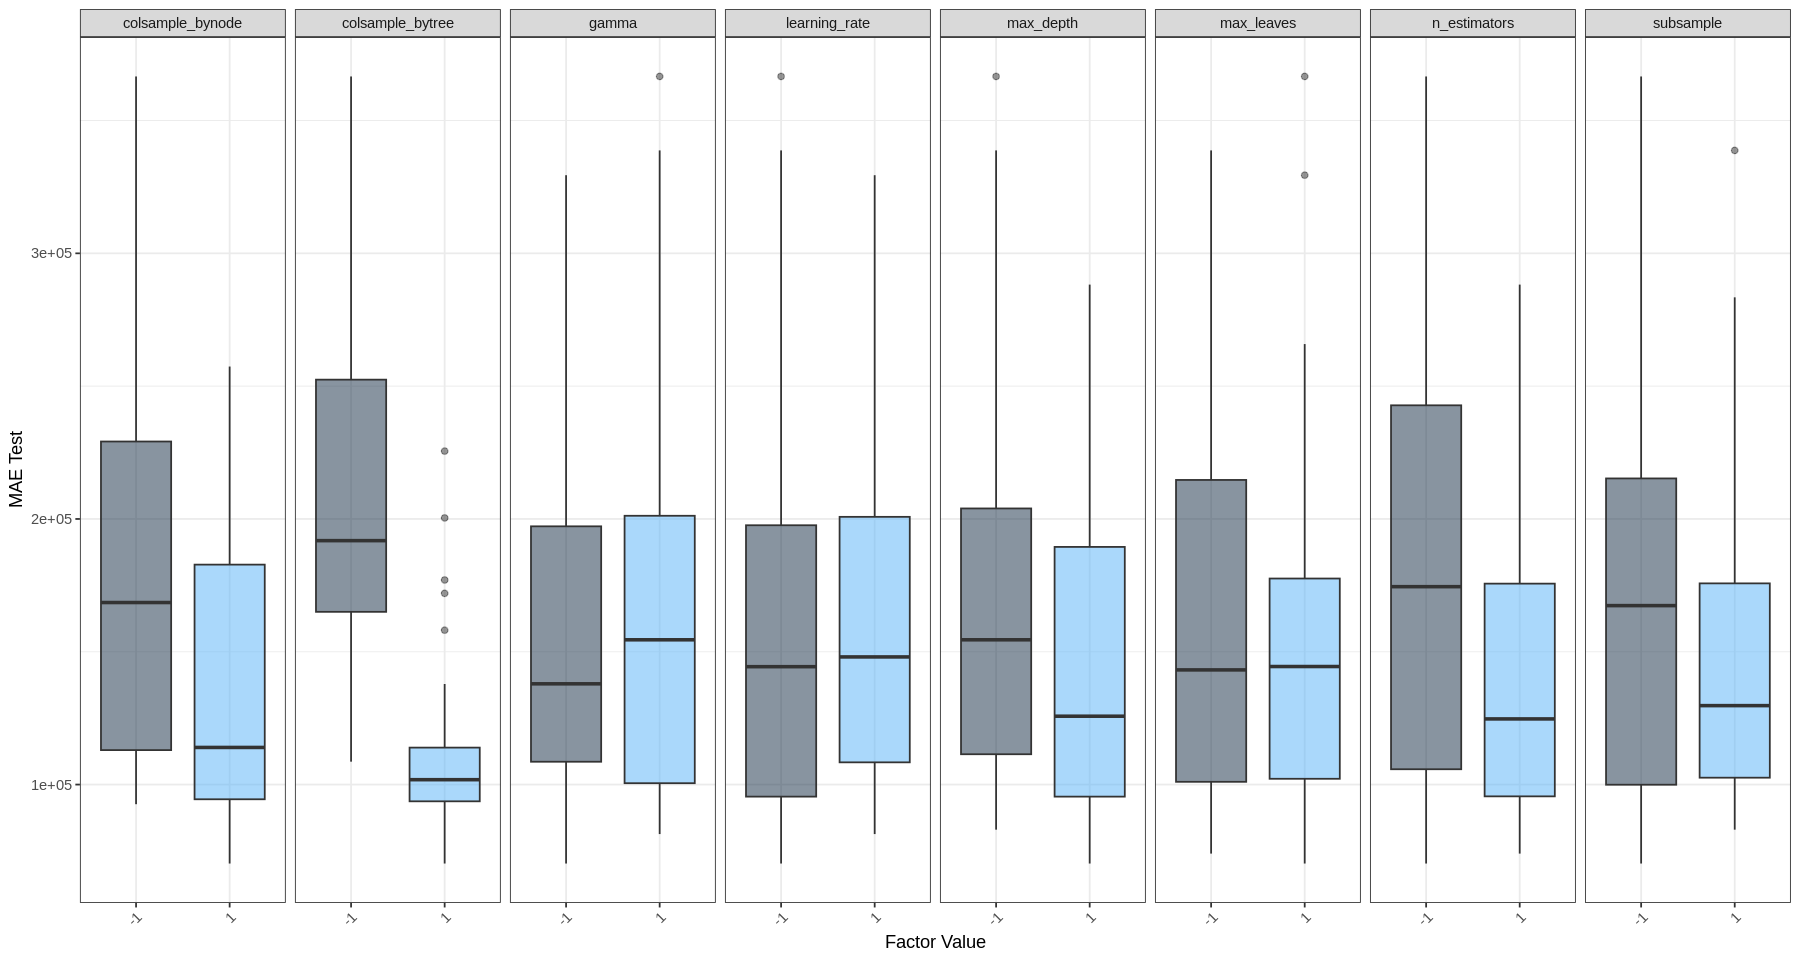

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(df_long, aes(x = factor(Value), y = test_mae, fill = Value)) +
  geom_boxplot(alpha=0.5) +
  facet_grid(. ~ Factor, shrink=FALSE) +
  labs(x = "Factor Value", y = "MAE Test") +
  theme_bw() +
  theme(legend.position = "none") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

In [ ]:
anova <- aov(test_mae~.,design)
summary(anova)

                 Df    Sum Sq   Mean Sq F value   Pr(>F)    
colsample_bytree  1 1.455e+11 1.455e+11  92.359 2.27e-13 ***
colsample_bynode  1 3.370e+10 3.370e+10  21.389 2.32e-05 ***
max_depth         1 8.819e+09 8.819e+09   5.598   0.0215 *  
learning_rate     1 1.743e+08 1.743e+08   0.111   0.7407    
n_estimators      1 3.264e+10 3.264e+10  20.716 2.99e-05 ***
subsample         1 6.653e+09 6.653e+09   4.223   0.0446 *  
gamma             1 6.210e+08 6.210e+08   0.394   0.5327    
max_leaves        1 6.053e+08 6.053e+08   0.384   0.5379    
Residuals        55 8.665e+10 1.575e+09                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [ ]:
lm_for_coeffs <- lm(test_mae~., data=design)
effects <-as.data.frame(2*lm_for_coeffs$coefficients)
names(effects)[1] <- 'Main Effects'
head(effects, 9)

,Main Effects
,<dbl>
(Intercept),321002.763
colsample_bytree,-95362.753
colsample_bynode,-45891.384
max_depth,-23477.622
learning_rate,3300.787
n_estimators,-45163.869
subsample,-20391.602
gamma,6230.058
max_leaves,-6150.659


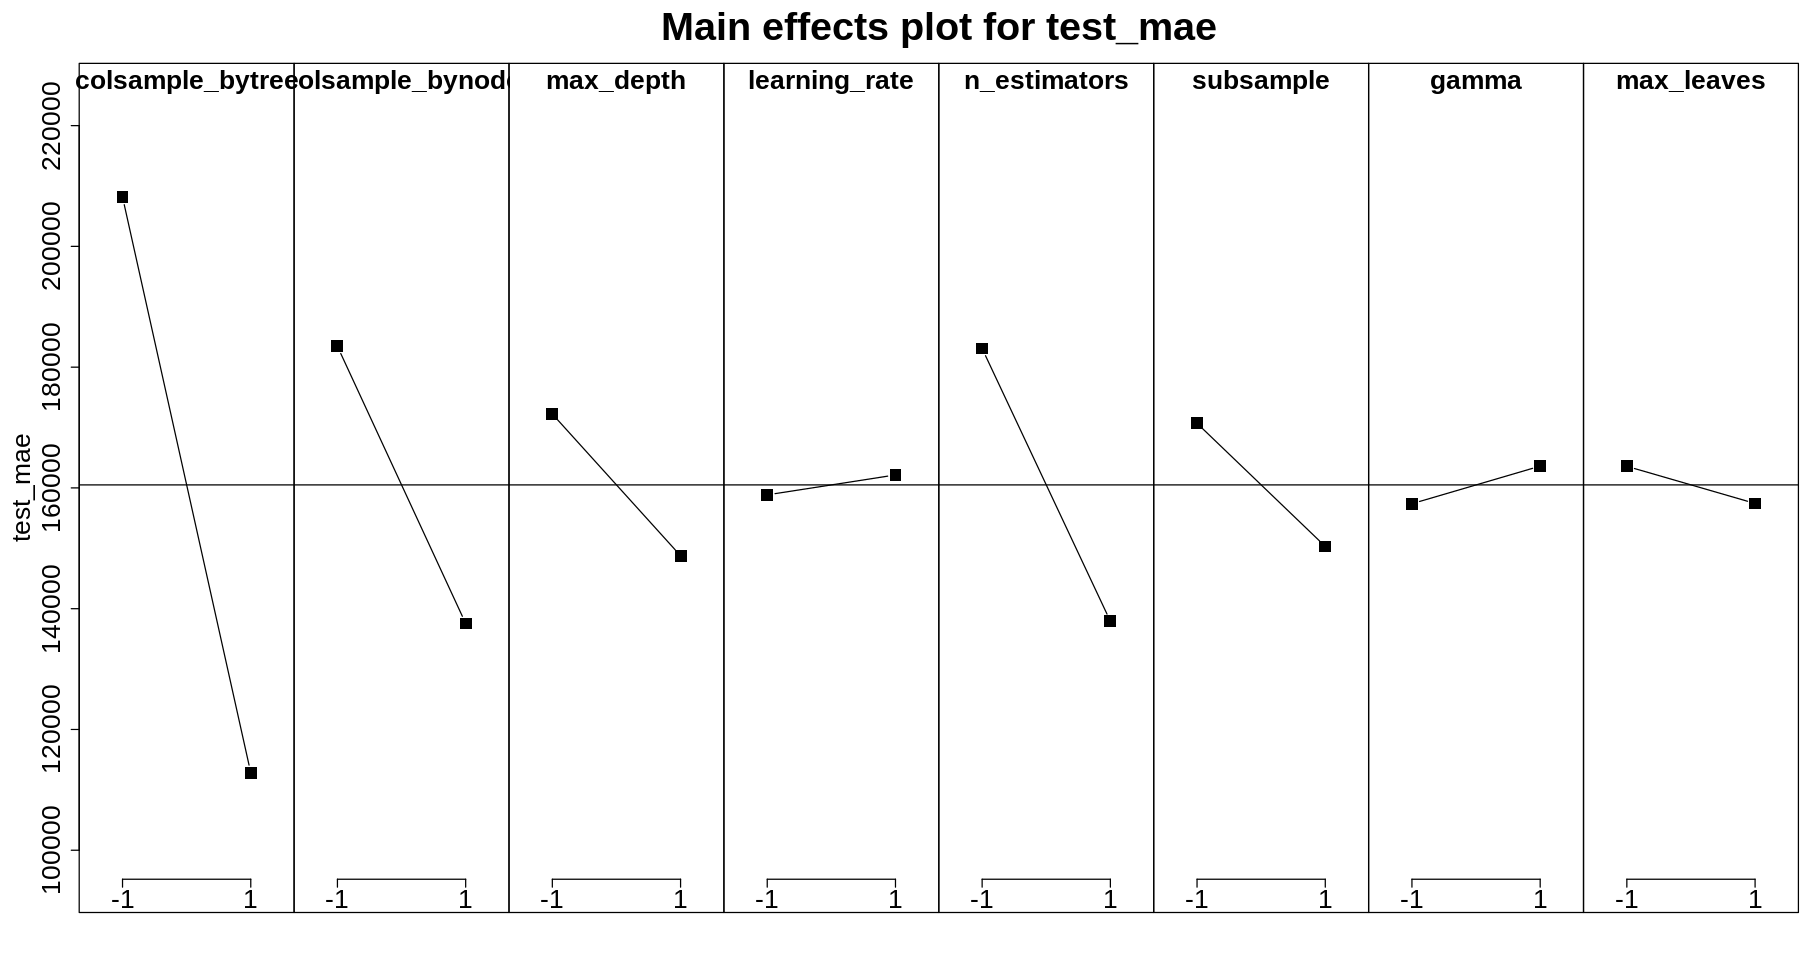

In [ ]:
MEPlot(design, cex.xax = 2, cex.main = 2)

Graf hlavných efektov poukazuje na to, že medzi navplyvnejšie
faktory patrí `colsample_bytree`, `colsample_bynode`, a `n_estimators`


# Grafická analýza významných faktorov a ich interakcii

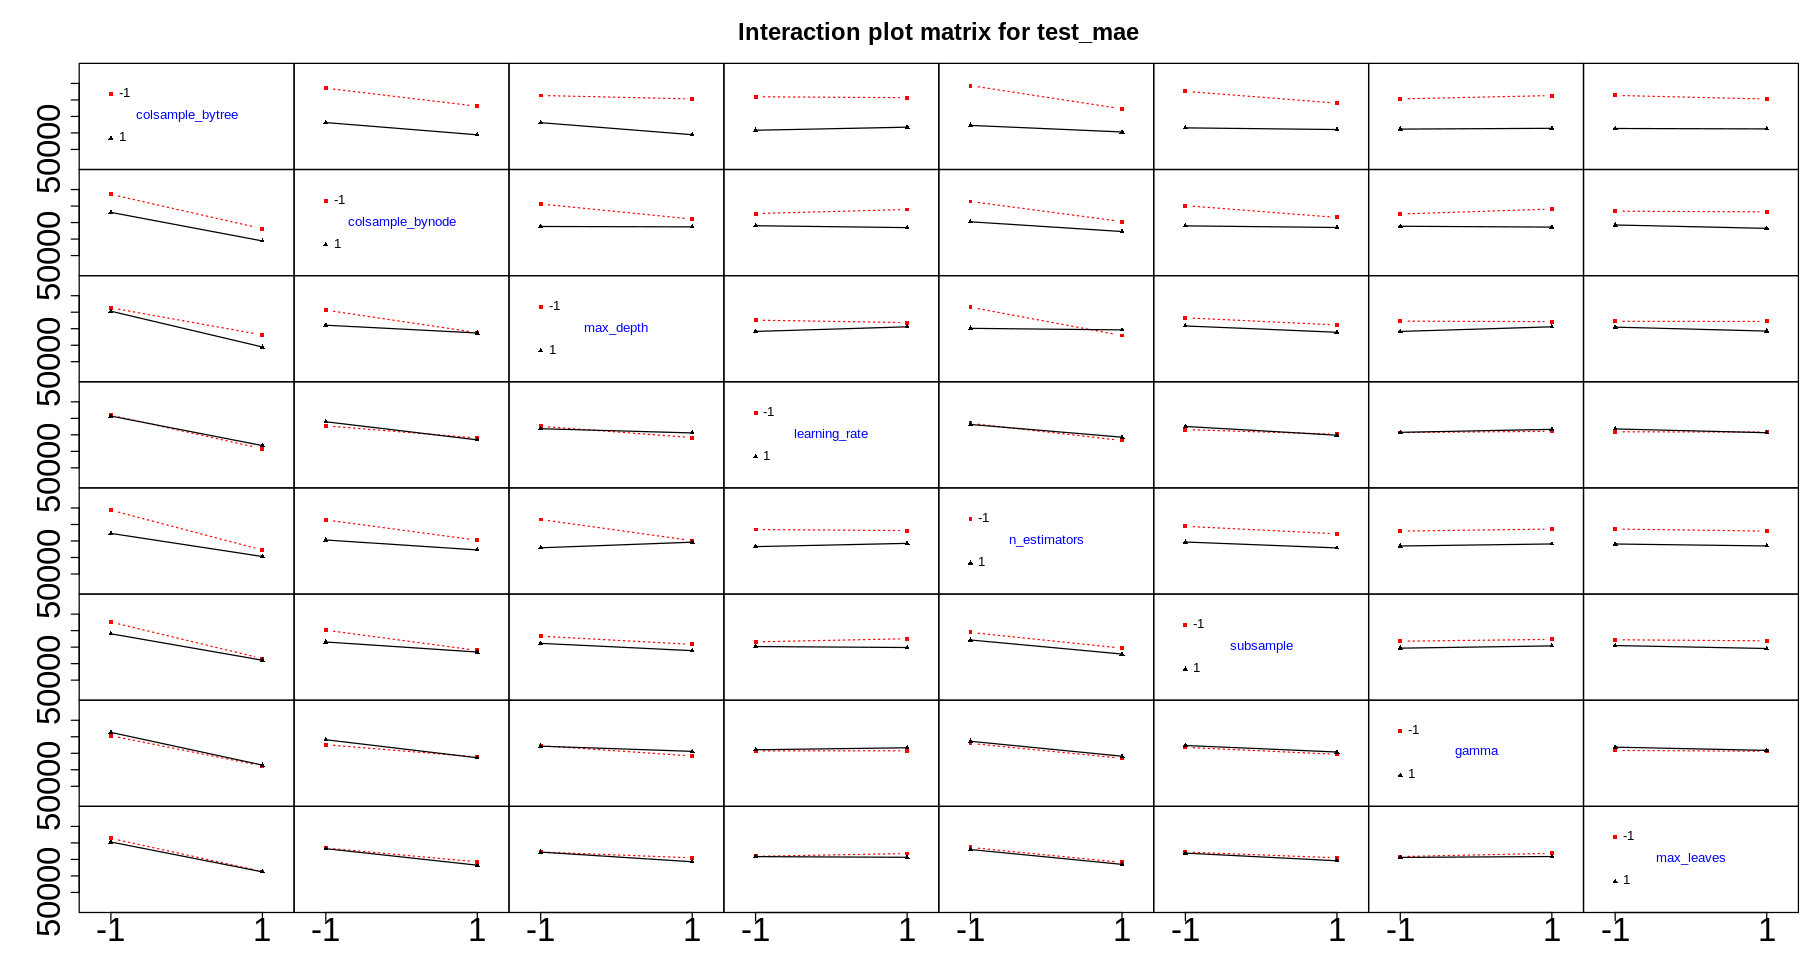

In [ ]:
IAPlot(design, cex.xax = 2.5, cex.main = 2.5)

Podľa interakčného grafu sa zdá, že `colsample_bytree`, `colsample_bynode`, a `n_estimators` faktory vykazujú čiastočné interakcie prvého rádu so všetkými ostatnými skúmanými faktormi. Verifikácie tejto hypotézy bude vykonaná pomocou ANOVA analýzy.


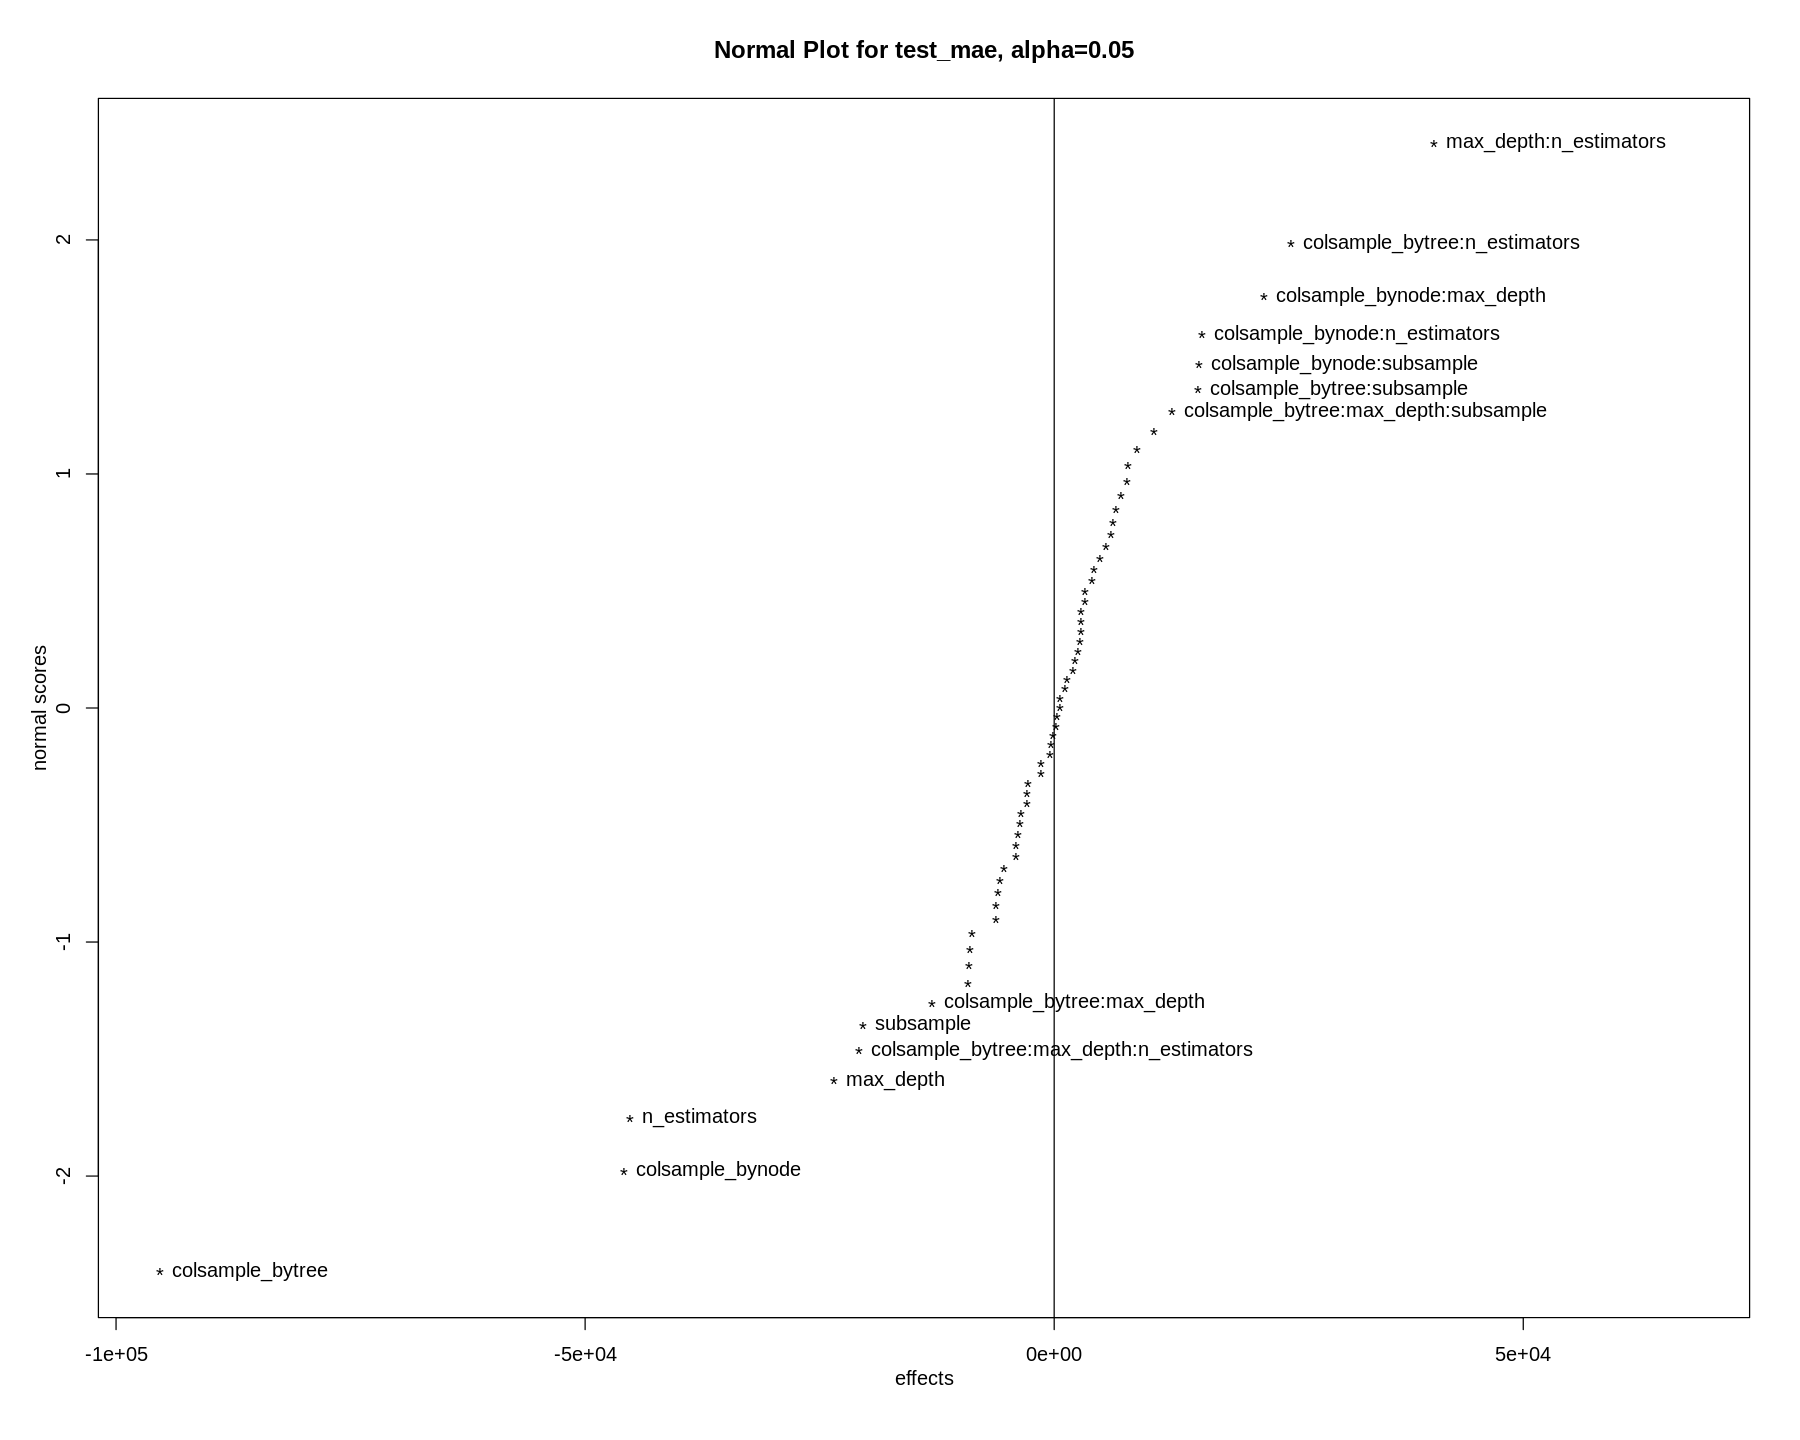

In [ ]:
# Daniel plot
options(repr.plot.width=15, repr.plot.height=12)

DP = DanielPlot(design)
qqline(DanielPlot(design)$y)


Podľa teórie patria medzi významné faktory tie ktoré sa výrazne ďaleko od `normálnej priamky` a teda v našom prípade tento graf opäť okrem iného poukazuje na významnosť faktorov
`colsample_bytree`, `colsample_bynode`, `n_estimators` a tiež niektorých interakcii ako napr. `max_depth:n_estimators` čo sa týka ich vplyvu na výslednú hodnotu testovacej metriky MAE. 


In [ ]:
# alternative to extract main effects from Daniel plot

effects <- cbind(DP$effect, DP$x)
effects[1:9,]

colsample_bytree,-95362.7532673922
colsample_bynode,-45891.3835943857
max_depth,-23477.6216499695
learning_rate,3300.78653885274
n_estimators,-45163.8687830553
subsample,-20391.6020646867
gamma,6230.05768155003
max_leaves,-6150.65895163751
colsample_bytree:colsample_bynode,8805.09308253661


# ANOVA

Najprv nafitujeme model so všetkými premennými ich interakciami prvého rádu.

In [13]:
# Resolution V factorial design means that 3 way interactions are aliased
# with 2 way interactions, hence we can't estimate them. 
#Any higher interaction is then also aliased.
# First attempt model:
summary(aov(test_mae~(.)^2 + colsample_bytree:max_depth:subsample + colsample_bytree:max_depth:n_estimators, data=design))

                                        Df    Sum Sq   Mean Sq F value   Pr(>F)
colsample_bytree                         1 1.455e+11 1.455e+11 474.971  < 2e-16
colsample_bynode                         1 3.370e+10 3.370e+10 109.995 1.22e-10
max_depth                                1 8.819e+09 8.819e+09  28.788 1.45e-05
learning_rate                            1 1.743e+08 1.743e+08   0.569  0.45769
n_estimators                             1 3.264e+10 3.264e+10 106.535 1.69e-10
subsample                                1 6.653e+09 6.653e+09  21.718 8.99e-05
gamma                                    1 6.210e+08 6.210e+08   2.027  0.16687
max_leaves                               1 6.053e+08 6.053e+08   1.976  0.17214
colsample_bytree:colsample_bynode        1 1.240e+09 1.240e+09   4.049  0.05508
colsample_bytree:max_depth               1 2.711e+09 2.711e+09   8.849  0.00642
colsample_bytree:learning_rate           1 5.792e+08 5.792e+08   1.891  0.18133
colsample_bytree:n_estimators           

In [9]:

# Final Model
summary(aov(test_mae~colsample_bytree +colsample_bynode + colsample_bytree:max_depth +
         colsample_bytree:n_estimators + colsample_bynode:max_depth + colsample_bytree:subsample + 
         subsample + colsample_bynode:n_estimators + colsample_bynode:subsample +max_depth:n_estimators +
          max_depth + n_estimators, data=design))

                              Df    Sum Sq   Mean Sq F value   Pr(>F)    
colsample_bytree               1 1.455e+11 1.455e+11 252.244  < 2e-16 ***
colsample_bynode               1 3.370e+10 3.370e+10  58.415 5.27e-10 ***
subsample                      1 6.653e+09 6.653e+09  11.534 0.001332 ** 
max_depth                      1 8.819e+09 8.819e+09  15.289 0.000273 ***
n_estimators                   1 3.264e+10 3.264e+10  56.578 8.18e-10 ***
colsample_bytree:max_depth     1 2.711e+09 2.711e+09   4.699 0.034864 *  
colsample_bytree:n_estimators  1 1.023e+10 1.023e+10  17.727 0.000104 ***
colsample_bynode:max_depth     1 7.992e+09 7.992e+09  13.854 0.000494 ***
colsample_bytree:subsample     1 3.749e+09 3.749e+09   6.500 0.013838 *  
colsample_bynode:n_estimators  1 3.954e+09 3.954e+09   6.854 0.011613 *  
colsample_bynode:subsample     1 3.825e+09 3.825e+09   6.631 0.012965 *  
max_depth:n_estimators         1 2.617e+10 2.617e+10  45.374 1.42e-08 ***
Residuals                     51 2.942

# Test lineárnej závislosti pomocou meraní v centrálnych bodoch

In [ ]:
# dataframe with center point measurements only
data_center = measured_design[65:69, ]
data_center

,colsample_bytree,colsample_bynode,max_depth,learning_rate,n_estimators,subsample,gamma,max_leaves,test_mae,train_mae
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
65,0,0,0,0,0,0,0,0,100885.3,10149.37
66,0,0,0,0,0,0,0,0,100885.3,10149.37
67,0,0,0,0,0,0,0,0,100885.3,10149.37
68,0,0,0,0,0,0,0,0,100885.3,10149.37
69,0,0,0,0,0,0,0,0,100885.3,10149.37


In [ ]:
mean_mae = mean(design$test_mae)
mean_center = mean(data_center$test_mae)

mean_center
mean_mae

ss_pure_quadratic = (64*5)*(mean_center-mean_mae)*(mean_center-mean_mae) / (64+5)

ss_pure_quadratic

[1] 100885.3

[1] 160501.4

[1] 16482687575

In [ ]:
isCenter = c(rep(0,times=64),rep(1,times=5))
measured_design$isCenter = isCenter
summary(aov(test_mae~ isCenter + colsample_bytree*colsample_bynode*n_estimators*learning_rate*max_depth*subsample*gamma*max_leaves , data=measured_design))

                                            Df    Sum Sq   Mean Sq   F value
isCenter                                     1 1.648e+10 1.648e+10 1.661e+33
colsample_bytree                             1 1.455e+11 1.455e+11 1.466e+34
colsample_bynode                             1 3.370e+10 3.370e+10 3.395e+33
n_estimators                                 1 3.264e+10 3.264e+10 3.288e+33
learning_rate                                1 1.743e+08 1.743e+08 1.756e+31
max_depth                                    1 8.819e+09 8.819e+09 8.885e+32
subsample                                    1 6.653e+09 6.653e+09 6.703e+32
gamma                                        1 6.210e+08 6.210e+08 6.256e+31
max_leaves                                   1 6.053e+08 6.053e+08 6.098e+31
colsample_bytree:colsample_bynode            1 1.240e+09 1.240e+09 1.250e+32
colsample_bytree:n_estimators                1 1.023e+10 1.023e+10 1.030e+33
colsample_bynode:n_estimators                1 3.954e+09 3.954e+09 3.983e+32

Výsledok ANOVA analýzy poukazuje na to, že závislosť MAE metriky na faktoroch nie je čisto lineárna ale obsahuje aj 
kvadratické členy.

# Lineárny model

The variables were converted to numerical actual values (except variables implementation, internet and dtype)  .

In [ ]:
#  here I perform linear mapping {-1,0,1} -> {actual_low, center, actual_high}
# the equation is "y = x*(B-A)/2 + (A+B)/2
#     where "y" is actual value
#           "x" is factorial value, x is from set {-1,0,1}
#           "A" ("B") is the low (high) value of "y", i.e. actual value
data <- data_with_center %>% transmute(
                           implementation = as.factor(implementation),
                           sparsity = as.numeric(as.character(sparsity))*(0.8-0.2)/2 + (0.2+0.8)/2,
                           range = as.numeric(as.character(range))*(10000-10)/2 + (10+10000)/2,
                           dtype = as.factor(dtype),
                           size = as.numeric(as.character(size))*(150-50)/2 + (50+150)/2,
                           ram = as.numeric(as.character(ram))*(5.6-3.5)/2 + (3.5+5.6)/2,
                           internet = as.factor(internet),
                           temperature = as.numeric(as.character(temperature))*(30-20)/2 + (20+30)/2,
                           time = as.numeric(time)
                           )
# same centrer point are not exacely in the center
# I set back the original value
data$range[data$range == 5005] = 5000  # instead od 5005 there should be 5000
data$ram[data$ram == 4.55] = 4.5  # instead of 4.55 there should be 4.5

head(data)

,implementation,sparsity,range,dtype,size,ram,internet,temperature,time
,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
6,1,0.2,10000,-1,50,3.5,1,20,1.595020e-04
7,-1,0.8,10000,-1,50,3.5,1,20,1.035061e-01
10,1,0.2,10,1,50,3.5,1,20,1.978874e-05
11,-1,0.8,10,1,50,3.5,1,20,9.313273e-02
17,-1,0.2,10,-1,150,3.5,1,20,2.849526e+00
20,1,0.8,10,-1,150,3.5,1,20,3.945589e-03


Model with model with interaction up to second order:

In [ ]:
model_all = lm(time ~ (.)^2,data = data)
summary(model_all)


Call:
lm.default(formula = time ~ (.)^2, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5692 -0.1752  0.0107  0.1869  0.8655 

Coefficients: (2 not defined because of singularities)
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -3.876e+02  1.185e+03  -0.327 0.745487    
implementation1              2.060e+00  6.468e-01   3.185 0.002939 ** 
sparsity                    -1.829e-01  1.064e+00  -0.172 0.864467    
range                       -8.633e-03  2.637e-02  -0.327 0.745206    
dtype-1                     -8.534e+01  2.639e+02  -0.323 0.748226    
size                         4.298e+00  1.317e+01   0.326 0.745987    
ram                          5.252e-01  2.538e-01   2.069 0.045544 *  
internet-1                  -5.657e-01  6.468e-01  -0.875 0.387449    
temperature                  1.715e+01  5.268e+01   0.325 0.746658    
implementation1:sparsity     2.717e-01  2.929e-01   0.927 0.359694    
implementation

Model only with intercept:

In [ ]:
model_quantit_1 = lm(time ~ implementation + ram + size + implementation:size + implementation:ram + size:ram,data = data)
model_quantit_2 = lm(time ~ implementation + ram + size + implementation:size + implementation:ram + size:ram + ram:temperature + temperature,data = data)
anova(model_quantit_2, model_quantit_1)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,63,7.465065,NA,NA,NA,NA
2,65,8.512692,-2,-1.047626,4.420622,0.01597538


According to anova test, the first model was chosen. The final model has variables: implementation, ram, size.

# 7. Use a regression model with at least two numerical variables (even if they are less significant). Plot a contour plot for the two quantitative variables and find the optimal values (maximum/minimum response) in intervals increased by 10% compared to the extreme values from the experimental design. In the contour plot, use actual values instead of code values.

The final model from previous exercise was chosen.

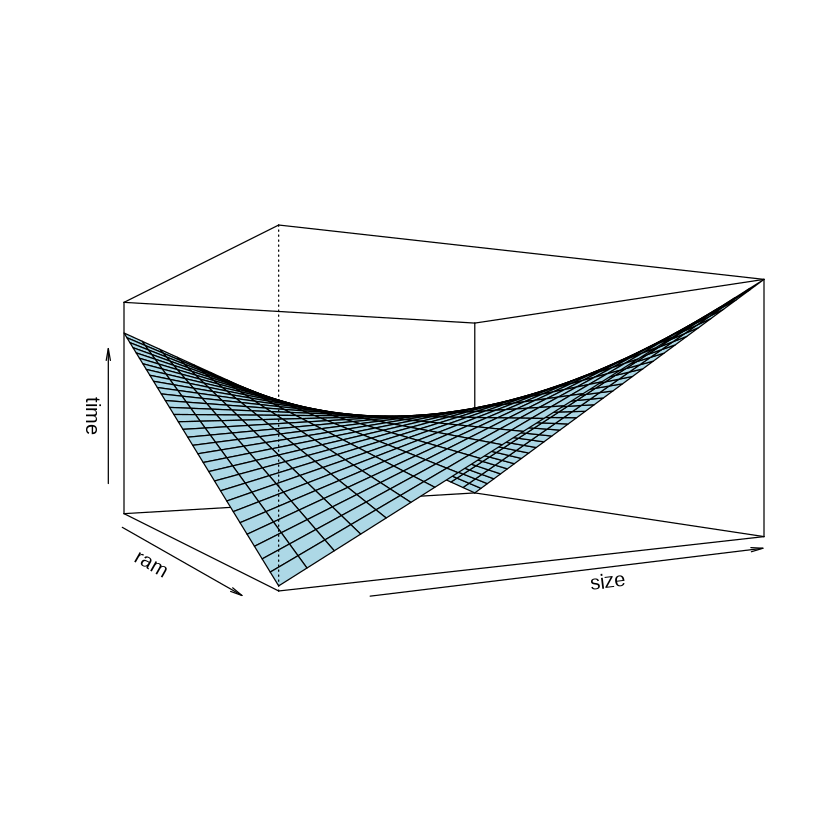

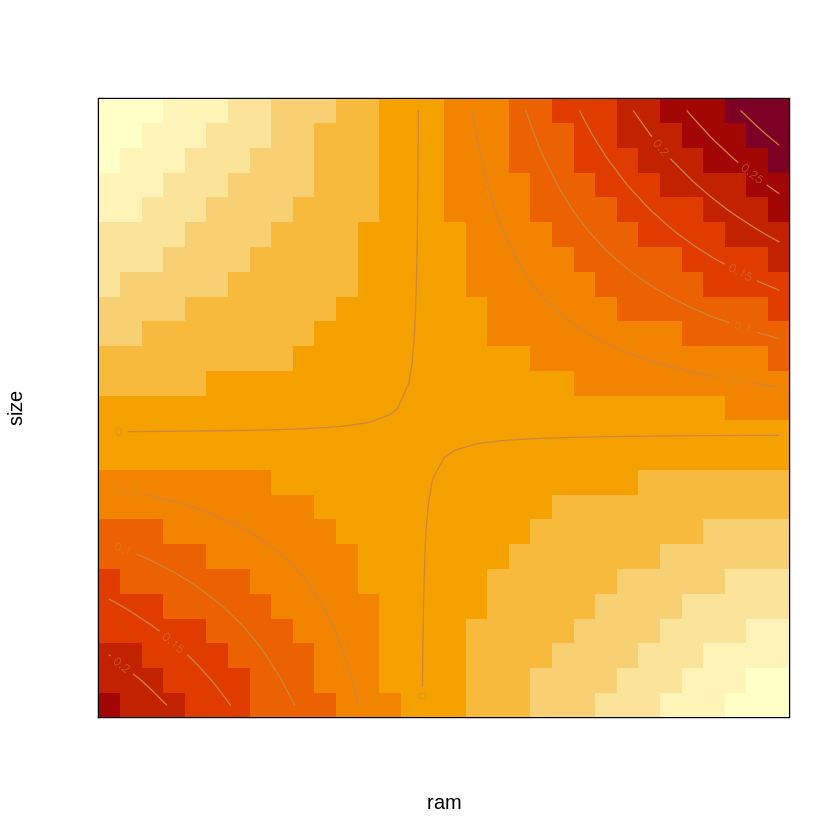

In [ ]:
x=seq(3.1,6.2,by=0.1)
y=seq(45,165,by=5)
impl = "1"
f = function(x,y){
    new.x=data.frame( x0=rep(impl,times=length(x)),x1=x,x2=y)
    colnames(new.x) <- c("implementation", "ram","size")

    predict(model_quantit_1, new.x)
}

# with implementation set to "1"
z = outer(x,y,f)
persp(x,y,z,theta=60,phi=0,expand=0.5,col="lightblue", xlab="ram",ylab="size",zlab="time")
image(x,y,z,axes=F,xlab="ram",ylab="size")

contour(x,y,z,levels=seq(0,3,by=0.05),add=T,col="peru")
axis(1,at=seq(-1,1,by=1),labels=c(3.1,4.6,6.2))
axis(2,at=seq(-1,1,by=1),labels=c(50,100,150))
box()

According to contour at implementation=1 (numpy implementation) the minimum is at (ram, size) = (3.1,165) and (ram, size) = (6.2,45)

In [ ]:
y1 = predict(model_quantit_1, data.frame(implementation="1", ram=3.1, size=165))
y2 = predict(model_quantit_1, data.frame(implementation="1", ram=6.2, size=45))
y = rbind(y1, y2)
y

,1
y1,-0.2876863
y2,-0.2790358


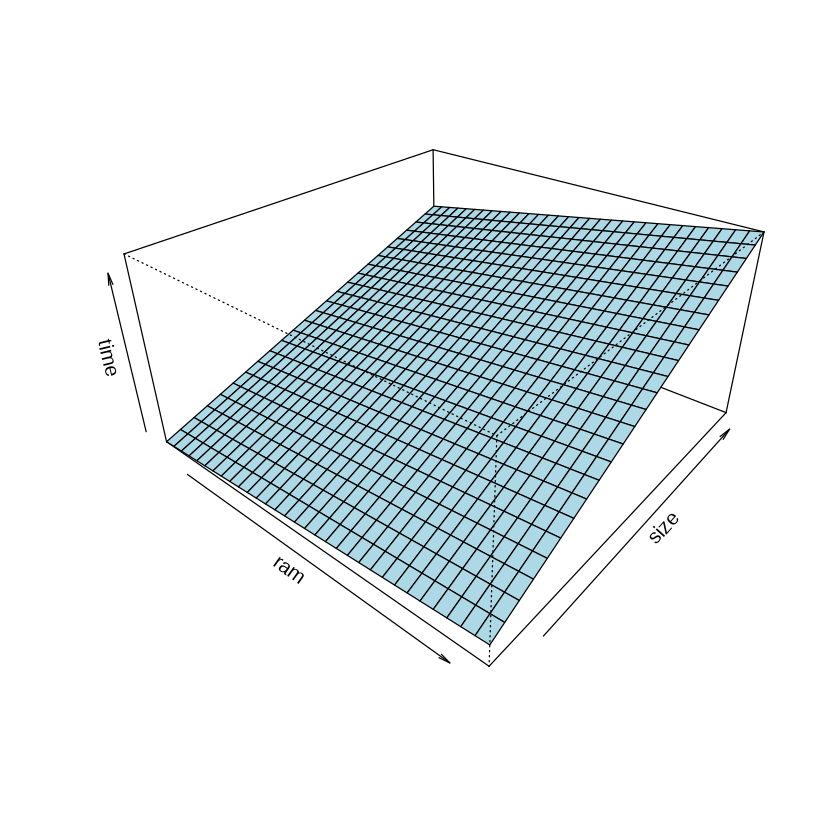

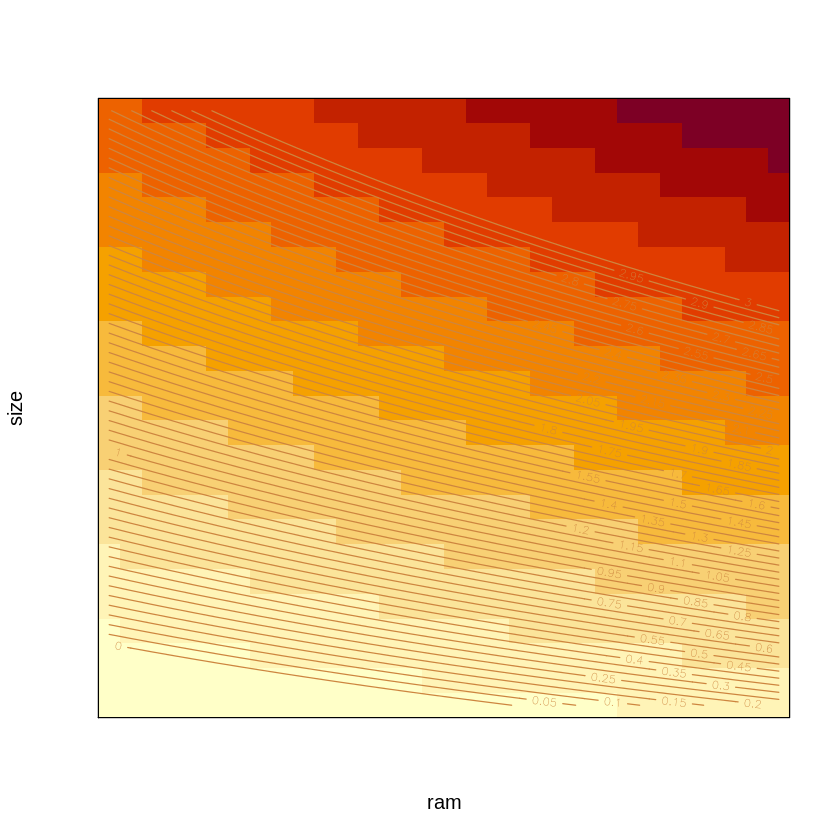

In [ ]:
x=seq(3.1,6.2,by=0.1)
y=seq(45,165,by=5)
impl = "-1"
f = function(x,y){
    new.x=data.frame( x0=rep(impl,times=length(x)),x1=x,x2=y)
    colnames(new.x) <- c("implementation", "ram","size")

    predict(model_quantit_1, new.x)
}

# with implementation set to "-1"
z = outer(x,y,f)
persp(x,y,z,theta=40,phi=30,expand=0.5,col="lightblue", xlab="ram",ylab="size",zlab="time")
image(x,y,z,axes=F,xlab="ram",ylab="size")

contour(x,y,z,levels=seq(0,3,by=0.05),add=T,col="peru")
axis(1,at=seq(-1,1,by=1),labels=c(3.1,4.6,6.2))
axis(2,at=seq(-1,1,by=1),labels=c(50,100,150))
box()

According to contour at implementation=-1 (own implementation) the minimum is at (ram, size) = (3.1,45). The minumum is:

In [ ]:
y = predict(model_quantit_1, data.frame(implementation="-1", ram=3.1, size=45))
y

1 
-0.314413

It is obvious, that by increasing intervals by 10 % we have violated the model assumption. Or that the model was wrong.